/home/tomsimpson/Documents/ETHwork/DynSub/Simple1DOF


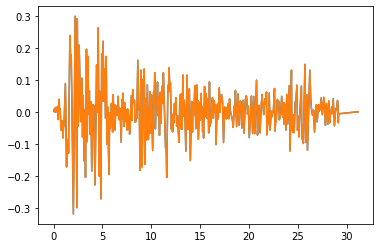

In [1]:
%cd Simple1DOF

import os
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint
from scipy.io import loadmat
from math import sqrt


os.getcwd()
Ag = loadmat('ElCentro.mat')
Ag = Ag['Ag']

plt.plot(Ag[:,0],Ag[:,1])

#Ag[:,1] = 0.75*Ag[:,1]
plt.plot(Ag[:,0], Ag[:,1])

In [139]:
def f(y, t, params):
    y1, y2, y3, y4, y5, y6, y7, y8 = y
    k, c, m, knl, Ag, ts = params
    i = int(t/ts)
    ag=Ag[i,1]
    derivs=[y2,
           (-m*ag*9.81-knl*y1**3-2*k*y1+k*y3-2*c*y2+c*y4)/m, y4, (-2*k*(y3)+k*y1+k*y5-2*c*y4+c*y2+c*y6)/m,
           y6,(-2*k*(y5)+k*y3+k*y7-2*c*y6+c*y4+c*y8)/m, y8, (-k*(y7-y5)-c*(y8-y6))/m ]
    
    
    
    return derivs

tStop = 31.2
ts = 0.02
t = np.arange(0., tStop, ts)
nt = len(t)


np.random.seed(1)
#Parameters
k = (176.75+1224.1)*1e6
m = 1.75e6
c = 0.04*sqrt(k*m)
knl = 0.5e12
knl = 0

params=[k, c, m, knl, Ag, ts]

#Initial values
y1_0=0
y2_0=0
y3_0=0
y4_0=0
y5_0=0
y6_0=0
y7_0=0
y8_0=0

y0 = [y1_0, y2_0, y3_0, y4_0, y5_0, y6_0, y7_0, y8_0]



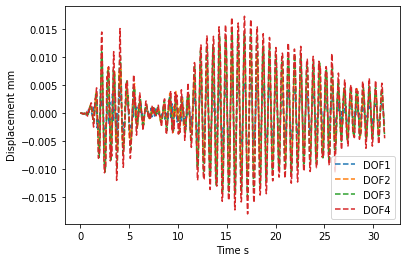

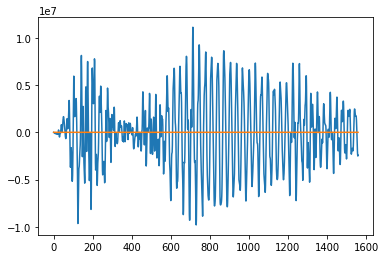

In [140]:
%matplotlib inline
import mpld3
mpld3.enable_notebook()

psoln = odeint(f, y0, t, args=(params,))

plt.figure(0)
plt.plot(Ag[:,0],psoln[:,0],'--', label='DOF1')
plt.plot(Ag[:,0], psoln[:,2],'--', label='DOF2')
plt.plot(Ag[:,0], psoln[:,4],'--', label='DOF3')
plt.plot(Ag[:,0], psoln[:,6],'--', label='DOF4')
plt.legend()
plt.xlabel('Time s')
plt.ylabel('Displacement mm')

plt.figure(1)

plt.figure(1)
plt.plot(k*psoln[:,0],label='lin')
plt.plot(knl*psoln[:,0]**3,label='nonlin')

In [141]:
F_exp = -(psoln[:,0:1]**3)*knl-psoln[:,0:1]*k
ExInps = np.concatenate((Ag[:,1:],F_exp),axis=1)
X = psoln[:,[0,2,4,6]]


f_train = ExInps[0:1000,:]
f_test = ExInps[:,:]

x_train = X[0:1000,:]
x_test = X[:,:]

datasetTrain = np.concatenate((f_train,x_train),axis=1)
datasetTest=np.concatenate((f_test,x_test),axis=1)

def create_dataset(dataset, look_back=6):
    X, Y = [], []
    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i+look_back), :]
        X.append(a)
        Y.append(dataset[i + look_back, 2:])
    return np.array(X), np.array(Y)

f_train, x_train = create_dataset(datasetTrain)
f_test, x_test = create_dataset(datasetTest)


print(f_train.shape)
print(x_train.shape)

(993, 6, 6)
(993, 4)


(993, 6, 6)
[[2.98390000e-01 9.79205678e+06 7.93083597e-03 1.24321194e-02
  1.45106623e-02 1.72957966e-02]]
[[-3.18820000e-01 -1.11099116e+07 -6.99008229e-03 -1.16994245e-02
  -1.50069004e-02 -1.80315197e-02]]
[0.00793084] [-0.00699008] [9792056.77916307] [-11109911.56180632]
8.086961023807666e-15


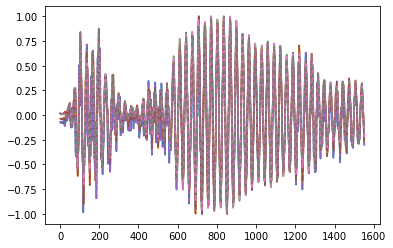

In [142]:

print(f_train.shape)
f_train = np.reshape(f_train,(f_train.shape[0],-1))
f_test = np.reshape(f_test,(f_test.shape[0],-1))
fmax=f_test.max(axis=0,keepdims=True)
fmin=f_test.min(axis=0,keepdims=True)
f_test_norm=2*(f_test-fmin)/(fmax-fmin)-1


xmax=x_test.max(axis=0,keepdims=True)
xmin=x_test.min(axis=0,keepdims=True)
x_test_norm=2*(x_test-xmin)/(xmax-xmin)-1

f_train_norm = f_test_norm[:1000,:]
x_train_norm = x_test_norm[:1000,:]


dispmax = fmax[:,2]
dispmin = fmin[:,2]

forcemax = fmax[:,1]
forcemin = fmin[:,1]

print(fmax[:,:6])
print(fmin[:,:6])

print(dispmax, dispmin, forcemax,forcemin)

params = [dispmax, dispmin, forcemax, forcemin]


from sklearn.linear_model import LinearRegression
reg = LinearRegression().fit(f_train_norm, x_train_norm)
#print(reg.score(f_train_norm,x_train_norm))
#print(reg.score(f_test_norm,x_test_norm))

yy = reg.predict(f_test_norm)

plt.plot(yy)
plt.plot(x_test_norm,'--')

from sklearn.metrics import mean_squared_error
print(mean_squared_error(yy,x_test_norm))

36
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_59 (Dense)             (None, 4)                 148       
Total params: 148
Trainable params: 148
Non-trainable params: 0
_________________________________________________________________
Train on 1000 samples, validate on 1553 samples
Epoch 1/4000
1000/1000 [==============================] - 2s 2ms/step - loss: 0.3845 - val_loss: 0.3143

Epoch 00001: val_loss improved from inf to 0.31428, saving model to .multi_mdl_wts_nl.hdf5
Epoch 2/4000
1000/1000 [==============================] - 0s 90us/step - loss: 0.3276 - val_loss: 0.2684

Epoch 00002: val_loss improved from 0.31428 to 0.26844, saving model to .multi_mdl_wts_nl.hdf5
Epoch 3/4000
1000/1000 [==============================] - 0s 62us/step - loss: 0.2816 - val_loss: 0.2315

Epoch 00003: val_loss improved from 0.26844 to 0.23151, saving model to .multi_mdl_wts_nl.hdf5
Epoch 4/4000
1000/1000 

1000/1000 [==============================] - 0s 26us/step - loss: 0.0243 - val_loss: 0.0208

Epoch 00039: val_loss improved from 0.02145 to 0.02083, saving model to .multi_mdl_wts_nl.hdf5
Epoch 40/4000
1000/1000 [==============================] - 0s 27us/step - loss: 0.0236 - val_loss: 0.0202

Epoch 00040: val_loss improved from 0.02083 to 0.02024, saving model to .multi_mdl_wts_nl.hdf5
Epoch 41/4000
1000/1000 [==============================] - 0s 26us/step - loss: 0.0230 - val_loss: 0.0197

Epoch 00041: val_loss improved from 0.02024 to 0.01967, saving model to .multi_mdl_wts_nl.hdf5
Epoch 42/4000
1000/1000 [==============================] - 0s 28us/step - loss: 0.0223 - val_loss: 0.0191

Epoch 00042: val_loss improved from 0.01967 to 0.01912, saving model to .multi_mdl_wts_nl.hdf5
Epoch 43/4000
1000/1000 [==============================] - 0s 28us/step - loss: 0.0217 - val_loss: 0.0186

Epoch 00043: val_loss improved from 0.01912 to 0.01859, saving model to .multi_mdl_wts_nl.hdf5
Epoc

Epoch 80/4000
1000/1000 [==============================] - 0s 34us/step - loss: 0.0092 - val_loss: 0.0078

Epoch 00080: val_loss improved from 0.00792 to 0.00777, saving model to .multi_mdl_wts_nl.hdf5
Epoch 81/4000
1000/1000 [==============================] - 0s 40us/step - loss: 0.0090 - val_loss: 0.0076

Epoch 00081: val_loss improved from 0.00777 to 0.00762, saving model to .multi_mdl_wts_nl.hdf5
Epoch 82/4000
1000/1000 [==============================] - 0s 32us/step - loss: 0.0089 - val_loss: 0.0075

Epoch 00082: val_loss improved from 0.00762 to 0.00748, saving model to .multi_mdl_wts_nl.hdf5
Epoch 83/4000
1000/1000 [==============================] - 0s 32us/step - loss: 0.0087 - val_loss: 0.0073

Epoch 00083: val_loss improved from 0.00748 to 0.00734, saving model to .multi_mdl_wts_nl.hdf5
Epoch 84/4000
1000/1000 [==============================] - 0s 32us/step - loss: 0.0085 - val_loss: 0.0072

Epoch 00084: val_loss improved from 0.00734 to 0.00720, saving model to .multi_mdl_wt


Epoch 00120: val_loss improved from 0.00390 to 0.00384, saving model to .multi_mdl_wts_nl.hdf5
Epoch 121/4000
1000/1000 [==============================] - 0s 28us/step - loss: 0.0045 - val_loss: 0.0038

Epoch 00121: val_loss improved from 0.00384 to 0.00377, saving model to .multi_mdl_wts_nl.hdf5
Epoch 122/4000
1000/1000 [==============================] - 0s 35us/step - loss: 0.0044 - val_loss: 0.0037

Epoch 00122: val_loss improved from 0.00377 to 0.00370, saving model to .multi_mdl_wts_nl.hdf5
Epoch 123/4000
1000/1000 [==============================] - 0s 27us/step - loss: 0.0044 - val_loss: 0.0036

Epoch 00123: val_loss improved from 0.00370 to 0.00364, saving model to .multi_mdl_wts_nl.hdf5
Epoch 124/4000
1000/1000 [==============================] - 0s 27us/step - loss: 0.0043 - val_loss: 0.0036

Epoch 00124: val_loss improved from 0.00364 to 0.00357, saving model to .multi_mdl_wts_nl.hdf5
Epoch 125/4000
1000/1000 [==============================] - 0s 27us/step - loss: 0.0042 - va

1000/1000 [==============================] - 0s 27us/step - loss: 0.0021 - val_loss: 0.0018

Epoch 00161: val_loss improved from 0.00179 to 0.00175, saving model to .multi_mdl_wts_nl.hdf5
Epoch 162/4000
1000/1000 [==============================] - 0s 26us/step - loss: 0.0021 - val_loss: 0.0017

Epoch 00162: val_loss improved from 0.00175 to 0.00172, saving model to .multi_mdl_wts_nl.hdf5
Epoch 163/4000
1000/1000 [==============================] - 0s 27us/step - loss: 0.0021 - val_loss: 0.0017

Epoch 00163: val_loss improved from 0.00172 to 0.00168, saving model to .multi_mdl_wts_nl.hdf5
Epoch 164/4000
1000/1000 [==============================] - 0s 38us/step - loss: 0.0020 - val_loss: 0.0016

Epoch 00164: val_loss improved from 0.00168 to 0.00165, saving model to .multi_mdl_wts_nl.hdf5
Epoch 165/4000
1000/1000 [==============================] - 0s 26us/step - loss: 0.0020 - val_loss: 0.0016

Epoch 00165: val_loss improved from 0.00165 to 0.00161, saving model to .multi_mdl_wts_nl.hdf5


1000/1000 [==============================] - 0s 28us/step - loss: 9.2115e-04 - val_loss: 7.3112e-04

Epoch 00201: val_loss improved from 0.00075 to 0.00073, saving model to .multi_mdl_wts_nl.hdf5
Epoch 202/4000
1000/1000 [==============================] - 0s 27us/step - loss: 9.0167e-04 - val_loss: 7.1494e-04

Epoch 00202: val_loss improved from 0.00073 to 0.00071, saving model to .multi_mdl_wts_nl.hdf5
Epoch 203/4000
1000/1000 [==============================] - 0s 32us/step - loss: 8.8262e-04 - val_loss: 6.9913e-04

Epoch 00203: val_loss improved from 0.00071 to 0.00070, saving model to .multi_mdl_wts_nl.hdf5
Epoch 204/4000
1000/1000 [==============================] - 0s 27us/step - loss: 8.6401e-04 - val_loss: 6.8368e-04

Epoch 00204: val_loss improved from 0.00070 to 0.00068, saving model to .multi_mdl_wts_nl.hdf5
Epoch 205/4000
1000/1000 [==============================] - 0s 28us/step - loss: 8.4582e-04 - val_loss: 6.6860e-04

Epoch 00205: val_loss improved from 0.00068 to 0.00067,

Epoch 240/4000
1000/1000 [==============================] - 0s 34us/step - loss: 4.2625e-04 - val_loss: 3.2378e-04

Epoch 00240: val_loss improved from 0.00033 to 0.00032, saving model to .multi_mdl_wts_nl.hdf5
Epoch 241/4000
1000/1000 [==============================] - 0s 29us/step - loss: 4.1909e-04 - val_loss: 3.1797e-04

Epoch 00241: val_loss improved from 0.00032 to 0.00032, saving model to .multi_mdl_wts_nl.hdf5
Epoch 242/4000
1000/1000 [==============================] - 0s 27us/step - loss: 4.1212e-04 - val_loss: 3.1233e-04

Epoch 00242: val_loss improved from 0.00032 to 0.00031, saving model to .multi_mdl_wts_nl.hdf5
Epoch 243/4000
1000/1000 [==============================] - 0s 26us/step - loss: 4.0535e-04 - val_loss: 3.0685e-04

Epoch 00243: val_loss improved from 0.00031 to 0.00031, saving model to .multi_mdl_wts_nl.hdf5
Epoch 244/4000
1000/1000 [==============================] - 0s 27us/step - loss: 3.9876e-04 - val_loss: 3.0152e-04

Epoch 00244: val_loss improved from 0.00

Epoch 279/4000
1000/1000 [==============================] - 0s 27us/step - loss: 2.5480e-04 - val_loss: 1.8681e-04

Epoch 00279: val_loss improved from 0.00019 to 0.00019, saving model to .multi_mdl_wts_nl.hdf5
Epoch 280/4000
1000/1000 [==============================] - 0s 33us/step - loss: 2.5240e-04 - val_loss: 1.8494e-04

Epoch 00280: val_loss improved from 0.00019 to 0.00018, saving model to .multi_mdl_wts_nl.hdf5
Epoch 281/4000
1000/1000 [==============================] - 0s 28us/step - loss: 2.5006e-04 - val_loss: 1.8311e-04

Epoch 00281: val_loss improved from 0.00018 to 0.00018, saving model to .multi_mdl_wts_nl.hdf5
Epoch 282/4000
1000/1000 [==============================] - 0s 25us/step - loss: 2.4777e-04 - val_loss: 1.8134e-04

Epoch 00282: val_loss improved from 0.00018 to 0.00018, saving model to .multi_mdl_wts_nl.hdf5
Epoch 283/4000
1000/1000 [==============================] - 0s 28us/step - loss: 2.4554e-04 - val_loss: 1.7961e-04

Epoch 00283: val_loss improved from 0.00

Epoch 318/4000
1000/1000 [==============================] - 0s 33us/step - loss: 1.9140e-04 - val_loss: 1.3827e-04

Epoch 00318: val_loss improved from 0.00014 to 0.00014, saving model to .multi_mdl_wts_nl.hdf5
Epoch 319/4000
1000/1000 [==============================] - 0s 34us/step - loss: 1.9028e-04 - val_loss: 1.3743e-04

Epoch 00319: val_loss improved from 0.00014 to 0.00014, saving model to .multi_mdl_wts_nl.hdf5
Epoch 320/4000
1000/1000 [==============================] - 0s 37us/step - loss: 1.8918e-04 - val_loss: 1.3661e-04

Epoch 00320: val_loss improved from 0.00014 to 0.00014, saving model to .multi_mdl_wts_nl.hdf5
Epoch 321/4000
1000/1000 [==============================] - 0s 34us/step - loss: 1.8809e-04 - val_loss: 1.3579e-04

Epoch 00321: val_loss improved from 0.00014 to 0.00014, saving model to .multi_mdl_wts_nl.hdf5
Epoch 322/4000
1000/1000 [==============================] - 0s 37us/step - loss: 1.8701e-04 - val_loss: 1.3499e-04

Epoch 00322: val_loss improved from 0.00

1000/1000 [==============================] - 0s 29us/step - loss: 1.5506e-04 - val_loss: 1.1133e-04

Epoch 00357: val_loss improved from 0.00011 to 0.00011, saving model to .multi_mdl_wts_nl.hdf5
Epoch 358/4000
1000/1000 [==============================] - 0s 30us/step - loss: 1.5426e-04 - val_loss: 1.1074e-04

Epoch 00358: val_loss improved from 0.00011 to 0.00011, saving model to .multi_mdl_wts_nl.hdf5
Epoch 359/4000
1000/1000 [==============================] - 0s 60us/step - loss: 1.5347e-04 - val_loss: 1.1016e-04

Epoch 00359: val_loss improved from 0.00011 to 0.00011, saving model to .multi_mdl_wts_nl.hdf5
Epoch 360/4000
1000/1000 [==============================] - 0s 38us/step - loss: 1.5268e-04 - val_loss: 1.0958e-04

Epoch 00360: val_loss improved from 0.00011 to 0.00011, saving model to .multi_mdl_wts_nl.hdf5
Epoch 361/4000
1000/1000 [==============================] - 0s 51us/step - loss: 1.5190e-04 - val_loss: 1.0900e-04

Epoch 00361: val_loss improved from 0.00011 to 0.00011,

Epoch 396/4000
1000/1000 [==============================] - 0s 67us/step - loss: 1.2693e-04 - val_loss: 9.0859e-05

Epoch 00396: val_loss improved from 0.00009 to 0.00009, saving model to .multi_mdl_wts_nl.hdf5
Epoch 397/4000
1000/1000 [==============================] - 0s 59us/step - loss: 1.2628e-04 - val_loss: 9.0396e-05

Epoch 00397: val_loss improved from 0.00009 to 0.00009, saving model to .multi_mdl_wts_nl.hdf5
Epoch 398/4000
1000/1000 [==============================] - 0s 47us/step - loss: 1.2563e-04 - val_loss: 8.9936e-05

Epoch 00398: val_loss improved from 0.00009 to 0.00009, saving model to .multi_mdl_wts_nl.hdf5
Epoch 399/4000
1000/1000 [==============================] - 0s 41us/step - loss: 1.2499e-04 - val_loss: 8.9478e-05

Epoch 00399: val_loss improved from 0.00009 to 0.00009, saving model to .multi_mdl_wts_nl.hdf5
Epoch 400/4000
1000/1000 [==============================] - 0s 44us/step - loss: 1.2436e-04 - val_loss: 8.9023e-05

Epoch 00400: val_loss improved from 0.00

1000/1000 [==============================] - 0s 90us/step - loss: 1.0395e-04 - val_loss: 7.4120e-05

Epoch 00435: val_loss improved from 0.00007 to 0.00007, saving model to .multi_mdl_wts_nl.hdf5
Epoch 436/4000
1000/1000 [==============================] - 0s 103us/step - loss: 1.0341e-04 - val_loss: 7.3732e-05

Epoch 00436: val_loss improved from 0.00007 to 0.00007, saving model to .multi_mdl_wts_nl.hdf5
Epoch 437/4000
1000/1000 [==============================] - 0s 87us/step - loss: 1.0288e-04 - val_loss: 7.3347e-05

Epoch 00437: val_loss improved from 0.00007 to 0.00007, saving model to .multi_mdl_wts_nl.hdf5
Epoch 438/4000
1000/1000 [==============================] - 0s 92us/step - loss: 1.0234e-04 - val_loss: 7.2965e-05

Epoch 00438: val_loss improved from 0.00007 to 0.00007, saving model to .multi_mdl_wts_nl.hdf5
Epoch 439/4000
1000/1000 [==============================] - 0s 86us/step - loss: 1.0182e-04 - val_loss: 7.2584e-05

Epoch 00439: val_loss improved from 0.00007 to 0.00007

1000/1000 [==============================] - 0s 55us/step - loss: 8.4861e-05 - val_loss: 6.0438e-05

Epoch 00474: val_loss improved from 0.00006 to 0.00006, saving model to .multi_mdl_wts_nl.hdf5
Epoch 475/4000
1000/1000 [==============================] - 0s 35us/step - loss: 8.4418e-05 - val_loss: 6.0119e-05

Epoch 00475: val_loss improved from 0.00006 to 0.00006, saving model to .multi_mdl_wts_nl.hdf5
Epoch 476/4000
1000/1000 [==============================] - 0s 48us/step - loss: 8.3970e-05 - val_loss: 5.9800e-05

Epoch 00476: val_loss improved from 0.00006 to 0.00006, saving model to .multi_mdl_wts_nl.hdf5
Epoch 477/4000
1000/1000 [==============================] - 0s 41us/step - loss: 8.3530e-05 - val_loss: 5.9484e-05

Epoch 00477: val_loss improved from 0.00006 to 0.00006, saving model to .multi_mdl_wts_nl.hdf5
Epoch 478/4000
1000/1000 [==============================] - 0s 37us/step - loss: 8.3086e-05 - val_loss: 5.9168e-05

Epoch 00478: val_loss improved from 0.00006 to 0.00006,

1000/1000 [==============================] - 0s 40us/step - loss: 6.8620e-05 - val_loss: 4.8828e-05

Epoch 00513: val_loss improved from 0.00005 to 0.00005, saving model to .multi_mdl_wts_nl.hdf5
Epoch 514/4000
1000/1000 [==============================] - 0s 35us/step - loss: 6.8234e-05 - val_loss: 4.8551e-05

Epoch 00514: val_loss improved from 0.00005 to 0.00005, saving model to .multi_mdl_wts_nl.hdf5
Epoch 515/4000
1000/1000 [==============================] - 0s 38us/step - loss: 6.7844e-05 - val_loss: 4.8274e-05

Epoch 00515: val_loss improved from 0.00005 to 0.00005, saving model to .multi_mdl_wts_nl.hdf5
Epoch 516/4000
1000/1000 [==============================] - 0s 46us/step - loss: 6.7462e-05 - val_loss: 4.7999e-05

Epoch 00516: val_loss improved from 0.00005 to 0.00005, saving model to .multi_mdl_wts_nl.hdf5
Epoch 517/4000
1000/1000 [==============================] - 0s 54us/step - loss: 6.7074e-05 - val_loss: 4.7725e-05

Epoch 00517: val_loss improved from 0.00005 to 0.00005,

1000/1000 [==============================] - 0s 48us/step - loss: 5.5254e-05 - val_loss: 3.9270e-05

Epoch 00553: val_loss improved from 0.00004 to 0.00004, saving model to .multi_mdl_wts_nl.hdf5
Epoch 554/4000
1000/1000 [==============================] - 0s 46us/step - loss: 5.4927e-05 - val_loss: 3.8961e-05

Epoch 00554: val_loss improved from 0.00004 to 0.00004, saving model to .multi_mdl_wts_nl.hdf5
Epoch 555/4000
1000/1000 [==============================] - 0s 37us/step - loss: 5.4584e-05 - val_loss: 3.8693e-05

Epoch 00555: val_loss improved from 0.00004 to 0.00004, saving model to .multi_mdl_wts_nl.hdf5
Epoch 556/4000
1000/1000 [==============================] - 0s 37us/step - loss: 5.4229e-05 - val_loss: 3.8438e-05

Epoch 00556: val_loss improved from 0.00004 to 0.00004, saving model to .multi_mdl_wts_nl.hdf5
Epoch 557/4000
1000/1000 [==============================] - 0s 37us/step - loss: 5.3896e-05 - val_loss: 3.8245e-05

Epoch 00557: val_loss improved from 0.00004 to 0.00004,

1000/1000 [==============================] - 0s 42us/step - loss: 4.4460e-05 - val_loss: 3.2013e-05

Epoch 00593: val_loss improved from 0.00003 to 0.00003, saving model to .multi_mdl_wts_nl.hdf5
Epoch 594/4000
1000/1000 [==============================] - 0s 29us/step - loss: 4.4324e-05 - val_loss: 3.2043e-05

Epoch 00594: val_loss did not improve from 0.00003
Epoch 595/4000
1000/1000 [==============================] - 0s 43us/step - loss: 4.4453e-05 - val_loss: 3.2237e-05

Epoch 00595: val_loss did not improve from 0.00003
Epoch 596/4000
1000/1000 [==============================] - 0s 37us/step - loss: 4.4532e-05 - val_loss: 3.2388e-05

Epoch 00596: val_loss did not improve from 0.00003
Epoch 597/4000
1000/1000 [==============================] - 0s 47us/step - loss: 4.4831e-05 - val_loss: 3.2512e-05

Epoch 00597: val_loss did not improve from 0.00003
Epoch 598/4000
1000/1000 [==============================] - 0s 37us/step - loss: 4.4829e-05 - val_loss: 3.2199e-05

Epoch 00598: val_los

Epoch 634/4000
1000/1000 [==============================] - 0s 55us/step - loss: 3.6003e-05 - val_loss: 2.4758e-05

Epoch 00634: val_loss improved from 0.00003 to 0.00002, saving model to .multi_mdl_wts_nl.hdf5
Epoch 635/4000
1000/1000 [==============================] - 0s 40us/step - loss: 3.4894e-05 - val_loss: 2.4515e-05

Epoch 00635: val_loss improved from 0.00002 to 0.00002, saving model to .multi_mdl_wts_nl.hdf5
Epoch 636/4000
1000/1000 [==============================] - 0s 45us/step - loss: 3.4200e-05 - val_loss: 2.4323e-05

Epoch 00636: val_loss improved from 0.00002 to 0.00002, saving model to .multi_mdl_wts_nl.hdf5
Epoch 637/4000
1000/1000 [==============================] - 0s 35us/step - loss: 3.3935e-05 - val_loss: 2.4230e-05

Epoch 00637: val_loss improved from 0.00002 to 0.00002, saving model to .multi_mdl_wts_nl.hdf5
Epoch 638/4000
1000/1000 [==============================] - 0s 31us/step - loss: 3.3740e-05 - val_loss: 2.4168e-05

Epoch 00638: val_loss improved from 0.00

Epoch 674/4000
1000/1000 [==============================] - 0s 36us/step - loss: 2.6945e-05 - val_loss: 1.9312e-05

Epoch 00674: val_loss did not improve from 0.00002
Epoch 675/4000
1000/1000 [==============================] - 0s 34us/step - loss: 2.6993e-05 - val_loss: 1.9236e-05

Epoch 00675: val_loss improved from 0.00002 to 0.00002, saving model to .multi_mdl_wts_nl.hdf5
Epoch 676/4000
1000/1000 [==============================] - 0s 40us/step - loss: 2.7051e-05 - val_loss: 1.9120e-05

Epoch 00676: val_loss improved from 0.00002 to 0.00002, saving model to .multi_mdl_wts_nl.hdf5
Epoch 677/4000
1000/1000 [==============================] - 0s 30us/step - loss: 2.7091e-05 - val_loss: 1.8844e-05

Epoch 00677: val_loss improved from 0.00002 to 0.00002, saving model to .multi_mdl_wts_nl.hdf5
Epoch 678/4000
1000/1000 [==============================] - 0s 34us/step - loss: 2.7237e-05 - val_loss: 1.8531e-05

Epoch 00678: val_loss improved from 0.00002 to 0.00002, saving model to .multi_mdl_w


Epoch 00714: val_loss improved from 0.00001 to 0.00001, saving model to .multi_mdl_wts_nl.hdf5
Epoch 715/4000
1000/1000 [==============================] - 0s 87us/step - loss: 1.8516e-05 - val_loss: 1.3290e-05

Epoch 00715: val_loss improved from 0.00001 to 0.00001, saving model to .multi_mdl_wts_nl.hdf5
Epoch 716/4000
1000/1000 [==============================] - 0s 69us/step - loss: 1.8395e-05 - val_loss: 1.3284e-05

Epoch 00716: val_loss improved from 0.00001 to 0.00001, saving model to .multi_mdl_wts_nl.hdf5
Epoch 717/4000
1000/1000 [==============================] - 0s 60us/step - loss: 1.8310e-05 - val_loss: 1.3271e-05

Epoch 00717: val_loss improved from 0.00001 to 0.00001, saving model to .multi_mdl_wts_nl.hdf5
Epoch 718/4000
1000/1000 [==============================] - 0s 64us/step - loss: 1.8310e-05 - val_loss: 1.3315e-05

Epoch 00718: val_loss did not improve from 0.00001
Epoch 719/4000
1000/1000 [==============================] - 0s 85us/step - loss: 1.8351e-05 - val_loss: 

1000/1000 [==============================] - 0s 63us/step - loss: 1.4896e-05 - val_loss: 9.1038e-06

Epoch 00757: val_loss improved from 0.00001 to 0.00001, saving model to .multi_mdl_wts_nl.hdf5
Epoch 758/4000
1000/1000 [==============================] - 0s 70us/step - loss: 1.2925e-05 - val_loss: 8.7957e-06

Epoch 00758: val_loss improved from 0.00001 to 0.00001, saving model to .multi_mdl_wts_nl.hdf5
Epoch 759/4000
1000/1000 [==============================] - 0s 69us/step - loss: 1.1945e-05 - val_loss: 8.3732e-06

Epoch 00759: val_loss improved from 0.00001 to 0.00001, saving model to .multi_mdl_wts_nl.hdf5
Epoch 760/4000
1000/1000 [==============================] - 0s 63us/step - loss: 1.1722e-05 - val_loss: 8.2943e-06

Epoch 00760: val_loss improved from 0.00001 to 0.00001, saving model to .multi_mdl_wts_nl.hdf5
Epoch 761/4000
1000/1000 [==============================] - 0s 71us/step - loss: 1.1449e-05 - val_loss: 8.1839e-06

Epoch 00761: val_loss improved from 0.00001 to 0.00001,

Epoch 802/4000
1000/1000 [==============================] - 0s 49us/step - loss: 8.2064e-06 - val_loss: 5.6510e-06

Epoch 00802: val_loss improved from 0.00001 to 0.00001, saving model to .multi_mdl_wts_nl.hdf5
Epoch 803/4000
1000/1000 [==============================] - 0s 34us/step - loss: 7.7307e-06 - val_loss: 5.1999e-06

Epoch 00803: val_loss improved from 0.00001 to 0.00001, saving model to .multi_mdl_wts_nl.hdf5
Epoch 804/4000
1000/1000 [==============================] - 0s 34us/step - loss: 7.2140e-06 - val_loss: 4.8814e-06

Epoch 00804: val_loss improved from 0.00001 to 0.00000, saving model to .multi_mdl_wts_nl.hdf5
Epoch 805/4000
1000/1000 [==============================] - 0s 36us/step - loss: 6.8071e-06 - val_loss: 4.6299e-06

Epoch 00805: val_loss improved from 0.00000 to 0.00000, saving model to .multi_mdl_wts_nl.hdf5
Epoch 806/4000
1000/1000 [==============================] - 0s 31us/step - loss: 6.4719e-06 - val_loss: 4.4959e-06

Epoch 00806: val_loss improved from 0.00

1000/1000 [==============================] - 0s 35us/step - loss: 5.5682e-06 - val_loss: 3.7836e-06

Epoch 00846: val_loss did not improve from 0.00000
Epoch 847/4000
1000/1000 [==============================] - 0s 41us/step - loss: 5.0460e-06 - val_loss: 3.6675e-06

Epoch 00847: val_loss did not improve from 0.00000
Epoch 848/4000
1000/1000 [==============================] - 0s 44us/step - loss: 5.0137e-06 - val_loss: 3.5450e-06

Epoch 00848: val_loss did not improve from 0.00000
Epoch 849/4000
1000/1000 [==============================] - 0s 38us/step - loss: 4.8931e-06 - val_loss: 3.3549e-06

Epoch 00849: val_loss did not improve from 0.00000
Epoch 850/4000
1000/1000 [==============================] - 0s 46us/step - loss: 4.6306e-06 - val_loss: 3.1416e-06

Epoch 00850: val_loss did not improve from 0.00000
Epoch 851/4000
1000/1000 [==============================] - 0s 37us/step - loss: 4.3519e-06 - val_loss: 2.9987e-06

Epoch 00851: val_loss did not improve from 0.00000
Epoch 852/400


Epoch 00893: val_loss did not improve from 0.00000
Epoch 894/4000
1000/1000 [==============================] - 0s 93us/step - loss: 5.0669e-06 - val_loss: 3.8724e-06

Epoch 00894: val_loss did not improve from 0.00000
Epoch 895/4000
1000/1000 [==============================] - 0s 63us/step - loss: 5.1732e-06 - val_loss: 3.5602e-06

Epoch 00895: val_loss did not improve from 0.00000
Epoch 896/4000
1000/1000 [==============================] - 0s 38us/step - loss: 5.4096e-06 - val_loss: 2.9066e-06

Epoch 00896: val_loss did not improve from 0.00000
Epoch 897/4000
1000/1000 [==============================] - 0s 52us/step - loss: 5.2892e-06 - val_loss: 2.6830e-06

Epoch 00897: val_loss did not improve from 0.00000
Epoch 898/4000
1000/1000 [==============================] - 0s 39us/step - loss: 3.9624e-06 - val_loss: 2.2108e-06

Epoch 00898: val_loss did not improve from 0.00000
Epoch 899/4000
1000/1000 [==============================] - 0s 46us/step - loss: 3.1022e-06 - val_loss: 1.9542e-0

1000/1000 [==============================] - 0s 45us/step - loss: 3.0147e-06 - val_loss: 2.1957e-06

Epoch 00940: val_loss did not improve from 0.00000
Epoch 941/4000
1000/1000 [==============================] - 0s 33us/step - loss: 3.4589e-06 - val_loss: 2.1810e-06

Epoch 00941: val_loss did not improve from 0.00000
Epoch 942/4000
1000/1000 [==============================] - 0s 36us/step - loss: 3.4752e-06 - val_loss: 1.8472e-06

Epoch 00942: val_loss did not improve from 0.00000
Epoch 943/4000
1000/1000 [==============================] - 0s 38us/step - loss: 3.5024e-06 - val_loss: 1.6392e-06

Epoch 00943: val_loss did not improve from 0.00000
Epoch 944/4000
1000/1000 [==============================] - 0s 38us/step - loss: 2.6681e-06 - val_loss: 1.3434e-06

Epoch 00944: val_loss did not improve from 0.00000
Epoch 945/4000
1000/1000 [==============================] - 0s 32us/step - loss: 2.3397e-06 - val_loss: 1.1838e-06

Epoch 00945: val_loss improved from 0.00000 to 0.00000, saving m


Epoch 00987: val_loss did not improve from 0.00000
Epoch 988/4000
1000/1000 [==============================] - 0s 50us/step - loss: 2.2168e-06 - val_loss: 1.5282e-06

Epoch 00988: val_loss did not improve from 0.00000
Epoch 989/4000
1000/1000 [==============================] - 0s 70us/step - loss: 2.1346e-06 - val_loss: 1.3230e-06

Epoch 00989: val_loss did not improve from 0.00000
Epoch 990/4000
1000/1000 [==============================] - 0s 83us/step - loss: 1.8982e-06 - val_loss: 1.0976e-06

Epoch 00990: val_loss did not improve from 0.00000
Epoch 991/4000
1000/1000 [==============================] - 0s 71us/step - loss: 1.6121e-06 - val_loss: 9.0444e-07

Epoch 00991: val_loss did not improve from 0.00000
Epoch 992/4000
1000/1000 [==============================] - 0s 71us/step - loss: 1.3517e-06 - val_loss: 7.9544e-07

Epoch 00992: val_loss improved from 0.00000 to 0.00000, saving model to .multi_mdl_wts_nl.hdf5
Epoch 993/4000
1000/1000 [==============================] - 0s 62us/s

1000/1000 [==============================] - 0s 58us/step - loss: 3.6379e-06 - val_loss: 1.9045e-06

Epoch 01035: val_loss did not improve from 0.00000
Epoch 1036/4000
1000/1000 [==============================] - 0s 64us/step - loss: 4.2880e-06 - val_loss: 1.7337e-06

Epoch 01036: val_loss did not improve from 0.00000
Epoch 1037/4000
1000/1000 [==============================] - 0s 56us/step - loss: 2.7947e-06 - val_loss: 1.6442e-06

Epoch 01037: val_loss did not improve from 0.00000
Epoch 1038/4000
1000/1000 [==============================] - 0s 57us/step - loss: 1.9077e-06 - val_loss: 1.1598e-06

Epoch 01038: val_loss did not improve from 0.00000
Epoch 1039/4000
1000/1000 [==============================] - 0s 43us/step - loss: 1.5899e-06 - val_loss: 1.1285e-06

Epoch 01039: val_loss did not improve from 0.00000
Epoch 1040/4000
1000/1000 [==============================] - 0s 48us/step - loss: 1.5940e-06 - val_loss: 1.1233e-06

Epoch 01040: val_loss did not improve from 0.00000
Epoch 10

1000/1000 [==============================] - 0s 45us/step - loss: 2.2400e-06 - val_loss: 8.8185e-07

Epoch 01084: val_loss did not improve from 0.00000
Epoch 1085/4000
1000/1000 [==============================] - 0s 71us/step - loss: 3.0833e-06 - val_loss: 6.9120e-07

Epoch 01085: val_loss did not improve from 0.00000
Epoch 1086/4000
1000/1000 [==============================] - 0s 50us/step - loss: 2.4177e-06 - val_loss: 8.4673e-07

Epoch 01086: val_loss did not improve from 0.00000
Epoch 1087/4000
1000/1000 [==============================] - 0s 63us/step - loss: 8.2019e-07 - val_loss: 4.5382e-07

Epoch 01087: val_loss improved from 0.00000 to 0.00000, saving model to .multi_mdl_wts_nl.hdf5
Epoch 1088/4000
1000/1000 [==============================] - 0s 75us/step - loss: 6.7604e-07 - val_loss: 4.7191e-07

Epoch 01088: val_loss did not improve from 0.00000
Epoch 1089/4000
1000/1000 [==============================] - 0s 58us/step - loss: 5.7881e-07 - val_loss: 5.0092e-07

Epoch 01089: va


Epoch 01132: val_loss did not improve from 0.00000
Epoch 1133/4000
1000/1000 [==============================] - 0s 46us/step - loss: 1.0616e-06 - val_loss: 7.5972e-07

Epoch 01133: val_loss did not improve from 0.00000
Epoch 1134/4000
1000/1000 [==============================] - 0s 50us/step - loss: 9.4336e-07 - val_loss: 7.7903e-07

Epoch 01134: val_loss did not improve from 0.00000
Epoch 1135/4000
1000/1000 [==============================] - 0s 45us/step - loss: 9.0372e-07 - val_loss: 8.6557e-07

Epoch 01135: val_loss did not improve from 0.00000
Epoch 1136/4000
1000/1000 [==============================] - 0s 34us/step - loss: 9.4285e-07 - val_loss: 9.6709e-07

Epoch 01136: val_loss did not improve from 0.00000
Epoch 1137/4000
1000/1000 [==============================] - 0s 53us/step - loss: 1.0424e-06 - val_loss: 1.1365e-06

Epoch 01137: val_loss did not improve from 0.00000
Epoch 1138/4000
1000/1000 [==============================] - 0s 30us/step - loss: 1.3064e-06 - val_loss: 1.2

1000/1000 [==============================] - 0s 80us/step - loss: 3.4393e-06 - val_loss: 9.9221e-07

Epoch 01181: val_loss did not improve from 0.00000
Epoch 1182/4000
1000/1000 [==============================] - 0s 87us/step - loss: 1.7096e-06 - val_loss: 1.1075e-06

Epoch 01182: val_loss did not improve from 0.00000
Epoch 1183/4000
1000/1000 [==============================] - 0s 86us/step - loss: 9.2274e-07 - val_loss: 7.5734e-07

Epoch 01183: val_loss did not improve from 0.00000
Epoch 1184/4000
1000/1000 [==============================] - 0s 94us/step - loss: 8.1948e-07 - val_loss: 8.1638e-07

Epoch 01184: val_loss did not improve from 0.00000
Epoch 1185/4000
1000/1000 [==============================] - 0s 102us/step - loss: 8.3301e-07 - val_loss: 8.6406e-07

Epoch 01185: val_loss did not improve from 0.00000
Epoch 1186/4000
1000/1000 [==============================] - 0s 81us/step - loss: 9.6466e-07 - val_loss: 9.6784e-07

Epoch 01186: val_loss did not improve from 0.00000
Epoch 1

1000/1000 [==============================] - 0s 61us/step - loss: 7.4917e-07 - val_loss: 7.9549e-07

Epoch 01230: val_loss did not improve from 0.00000
Epoch 1231/4000
1000/1000 [==============================] - 0s 64us/step - loss: 9.3373e-07 - val_loss: 9.9542e-07

Epoch 01231: val_loss did not improve from 0.00000
Epoch 1232/4000
1000/1000 [==============================] - 0s 49us/step - loss: 1.1392e-06 - val_loss: 1.0973e-06

Epoch 01232: val_loss did not improve from 0.00000
Epoch 1233/4000
1000/1000 [==============================] - 0s 48us/step - loss: 1.7727e-06 - val_loss: 1.4447e-06

Epoch 01233: val_loss did not improve from 0.00000
Epoch 1234/4000
1000/1000 [==============================] - 0s 57us/step - loss: 2.4433e-06 - val_loss: 1.4737e-06

Epoch 01234: val_loss did not improve from 0.00000
Epoch 1235/4000
1000/1000 [==============================] - 0s 55us/step - loss: 3.3574e-06 - val_loss: 1.8171e-06

Epoch 01235: val_loss did not improve from 0.00000
Epoch 12

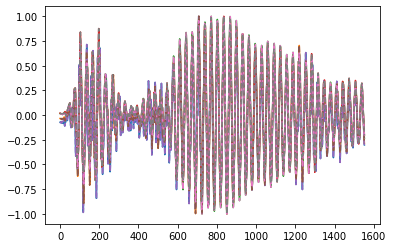

In [148]:
from keras.models import Sequential
from keras.layers import Dense
from keras.callbacks import ModelCheckpoint, EarlyStopping
from sklearn.preprocessing import normalize
import keras




usualCallback = EarlyStopping(monitor='val_loss', min_delta=1e-10, patience = 150)
checkpoint = ModelCheckpoint('.multi_mdl_wts_nl.hdf5', verbose=1, monitor='val_loss',save_best_only=True, mode='auto') 
callbacks_list = [usualCallback, checkpoint]

print(f_train.shape[1])

nn = Sequential()
nn.add(Dense(4,input_dim = f_train.shape[1], activation='linear'))
#nn.add(Dense(4,activation='linear'))
opt = keras.optimizers.Adam(lr=0.0005)
nn.compile(loss='mean_squared_error', optimizer=opt)

nn.summary()

#nn.load_weights('.multi_mdl_wts_nl.hdf5')
nn.fit(f_train_norm,x_train_norm,validation_data=(f_test_norm,x_test_norm) ,epochs=4000, batch_size=64, callbacks=callbacks_list,shuffle=False)

nn.load_weights('.multi_mdl_wts_nl.hdf5')
print(nn.evaluate(f_test_norm,x_test_norm))

yhat = nn.predict(f_test_norm)
plt.plot(yhat)
plt.plot(x_test_norm,'--')

print(mean_squared_error(yhat,x_test_norm))

(1500, 4)


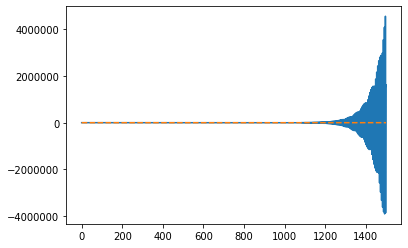

In [149]:

%matplotlib inline
import mpld3
mpld3.enable_notebook()


'''
def sim_pred(mdl, AG, X0, steps):
    Xhat = X0
    y = []
    Xstore = []
    for i in range(steps):
        #print(Xhat)
        Yhat = mdl.predict(Xhat)
        #RestForce = -Yhat*1224.1e6
        RestForce  = -Yhat
        #print(Yhat)
        y.append(Yhat)
        Xstore.append(Xhat)
        Xhat = Xhat[:,-3:]
        Xhat = np.concatenate((Xhat,AG[i+2:i+3,0:]),axis=1)
        Xhat = np.concatenate((Xhat,RestForce),axis=1)
        Xhat = np.concatenate((Xhat,Yhat),axis=1)   
        #print(Xhat.shape)
    
    
    return(y, Xstore)
'''

def sim_pred(mdl, AG, X0, steps, params):
    Xhat = X0
    y = []
    Xstore = []
    dispmax, dispmin, forcemax, forcemin = params
    for i in range(steps):
        #print(Xhat.shape) 
        Yhat = mdl.predict(Xhat)
        y_un = dispmin + (Yhat[:,0:1]+1)*(dispmax-dispmin)/2
        RestForce_un = -(y_un**3)*knl-y_un*k
        RestForce =(2*(RestForce_un-forcemin)/(forcemax-forcemin)-1)        
        #print(Yhat)
        y.append(Yhat)
        Xstore.append(Xhat)
        Xhat = Xhat[:,6:]
        
        Xhat = np.concatenate((Xhat,AG[i+1:i+2,0:]),axis=1)
        Xhat = np.concatenate((Xhat,RestForce),axis=1)
        Xhat = np.concatenate((Xhat,Yhat),axis=1)   
        #print(Xhat.shape)
    
    
    return(y, Xstore)
    

    
(y, Xstore)= sim_pred(nn, f_test_norm[0:,-6:-5], f_train_norm[0:1,:], 1500, params)

Xstore = np.asarray(Xstore)
Xstore = np.squeeze(Xstore)

'''
plt.plot(Xstore[:,1])
plt.plot(f_test_norm[:,1])
'''

y = np.asarray(np.squeeze(y))
print(y.shape)
plt.plot(y[:,0])
plt.plot(x_test_norm[0:y.shape[0]+0,0],'--')


In [29]:
X0 = f_train_norm[0:1,:]
Yhat1 = nn.predict(X0)
Y1 = x_test_norm[0:1]
#print(Yhat1.shape)

y_un = dispmin + (Yhat1[:,0:1]+1)*(dispmax-dispmin)/2
y_un_true = dispmin + (Y1[:,0:1]+1)*(dispmax-dispmin)/2

RestForce_un_true=-(y_un_true**3)*knl-y_un_true*k

RestForce_un = -(y_un**3)*knl-y_un*k
#print(RestForce_un_true)
#print(RestForce_un)


RestForce_true_un = forcemin +(f_train_norm[1:2,-5]+1)*(forcemax-forcemin)/2

#print(RestForce_true_un, RestForce_un)


RestForce =(2*(RestForce_un-forcemin)/(forcemax-forcemin)-1)

X1hat = X0[:,6:]
X1hat = np.concatenate((X1hat,f_test_norm[1:2,-6:-5]),axis=1)
X1hat = np.concatenate((X1hat,RestForce),axis=1)
X1hat = np.concatenate((X1hat,Yhat1),axis=1)

X1 = f_train_norm[1:2,:]
#print(X1[:,-6:])




Yhat2 = nn.predict(X1hat)
#print(Yhat2)
Y2 = x_test_norm[1:2]
#print(Y2)

y_un = dispmin + (Yhat2[:,0:1]+1)*(dispmax-dispmin)/2
RestForce_un = -(y_un**3)*knl-y_un*k
RestForce =(2*(RestForce_un-forcemin)/(forcemax-forcemin)-1)

X2hat = X1hat[:,6:]
X2hat = np.concatenate((X2hat,f_test_norm[2:3,-6:-5]),axis=1)
X2hat = np.concatenate((X2hat,RestForce),axis=1)
X2hat = np.concatenate((X2hat,Yhat2),axis=1)

X2 = f_train_norm[2:3,:]
Yhat3 = nn.predict(X2hat)
Y3 = x_test_norm[2:3]

#print(Y3hat, Y3)


y_un = dispmin + (Yhat3[:,0:1]+1)*(dispmax-dispmin)/2
RestForce_un = -(y_un**3)*knl-y_un*k
RestForce =(2*(RestForce_un-forcemin)/(forcemax-forcemin)-1)
X3hat = X2hat[:,6:]
X3hat = np.concatenate((X3hat,f_test_norm[3:4,-6:-5]),axis=1)
X3hat = np.concatenate((X3hat,RestForce),axis=1)
X3hat = np.concatenate((X3hat,Yhat3),axis=1)
X3 = f_train_norm[3:4,:]


Yhat4 = nn.predict(X3hat)
Y4 = x_test_norm[3:4]



y_un = dispmin + (Yhat4[:,0:1]+1)*(dispmax-dispmin)/2
RestForce_un = -(y_un**3)*knl-y_un*k
RestForce =(2*(RestForce_un-forcemin)/(forcemax-forcemin)-1)
X4hat = X3hat[:,6:]
X4hat = np.concatenate((X4hat,f_test_norm[4:5,-6:-5]),axis=1)
X4hat = np.concatenate((X4hat,RestForce),axis=1)
X4hat = np.concatenate((X4hat,Yhat4),axis=1)
X4 = f_train_norm[4:5,:]


Yhat5 = nn.predict(X4hat)
Y5 = x_test_norm[4:5]
print(Yhat5, Y5)



[[ 0.06247605  0.02389674 -0.00152063 -0.02692375]] [[ 0.06372778  0.02439674 -0.00102118 -0.02553623]]


In [66]:
print(y_un)

print(2*(y_un-dispmin)/(dispmax-dispmin)-1)
RestForce_un = -k * y_un
print(RestForce_un)
RestForce_norm = 2*(RestForce_un-forcemin)/(forcemax-forcemin)-1
print(RestForce_norm)



[[-0.00099282]]
[[-0.08280057]]
[[1390795.48845345]]
[[0.01519506]]
-1
